In [1]:
import xarray as xr
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import os

/glade/work/hpzhang/tools/anaconda3/envs/geocat/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
ff = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly.pkl").dropna()
df  = ff.drop(columns=['lat', 'lon', 'lsm', 'T1000', 'T700', 'EIS', 'ECTEI','ELF','SST', 'AOD'])
df = df[df.index.year.isin(np.arange(2003,2019))]
len(df)

5350237

In [3]:
df.head()

,LCF,TH1000,TH850,TH700,RH1000,RH850,RH700,Q1000,Q850,Q700,U1000,U700,OMEGA500,OMEGA700,PWV,LH,SH,Tadv,dQ,LTS
time,,,,,,,,,,,,,,,,,,,,
2003-01-15,0.590822,273.145630,277.822327,286.950775,85.577278,84.145813,69.974464,0.003216,0.002045,0.001219,3.637893,6.459276,0.004265,0.005796,8.286732,-14.891875,-1.580903,0.898143,0.001997,13.805145
2003-01-15,0.590822,273.192474,277.799255,286.895844,85.665604,84.507431,69.732834,0.003221,0.002052,0.001191,3.618882,6.377827,0.002914,0.010119,8.276699,-13.840185,-0.886921,-0.020427,0.002030,13.703369
2003-01-15,0.556442,273.239288,277.803558,286.847046,85.945564,84.507431,69.224571,0.003238,0.002052,0.001163,3.703815,6.273440,0.001923,0.008408,8.276699,-13.721111,-0.987361,-0.006477,0.002075,13.607758
2003-01-15,0.556442,273.258575,277.851196,286.802826,86.460487,84.855713,69.139580,0.003261,0.002063,0.001153,3.733388,6.172708,0.005346,0.004445,8.293421,-12.907546,-0.686019,0.069008,0.002108,13.544250
2003-01-15,0.584355,273.276489,277.882935,286.755585,86.692123,85.037354,69.027931,0.003274,0.002071,0.001152,3.706906,6.052912,0.009849,0.000932,8.286732,-12.451134,-0.850394,-1.276983,0.002122,13.479095


In [4]:
data = df
index_train = data.index.year.isin(np.arange(2003,2015))
index_test  = data.index.year.isin(np.arange(2015,2019))
data_train = data[index_train]
data_test  = data[index_test]

X_train, y_train = data_train.iloc[:,1:], data_train.iloc[:,0]
X_test, y_test   = data_test.iloc[:,1:], data_test.iloc[:,0]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

np.save("/glade/work/hpzhang/LCC_pred/data/X_test_scaled.npy", np.array(X_test_scaled))

In [7]:
len(X_train_scaled)*0.8

3208360.0

In [8]:
len(X_train_scaled)*0.2

802090.0

In [9]:
len(X_test_scaled)

1339787

In [28]:
import xgboost as xgb
import pickle

params =  {'colsample_bylevel': 0.8996518880817399,
 'colsample_bytree': 0.8853387899201755,
 'learning_rate': 0.16184400108442132,
 'max_depth': int(6.970737464733581),
 'n_estimators': int(869.9900903438686),
 'subsample': 0.9239287537315828}

model = xgb.XGBRegressor(tree_method='gpu_hist', 
                        eval_metric=mean_squared_error,
                        gpu_id=0, seed = 1001, n_jobs=-1, **params)
model.fit(X_train_scaled, y_train)

### save model ###
file_name = "/glade/work/hpzhang/LCC_pred/data/xgb_reg.pkl"
pickle.dump(model, open(file_name, "wb"))


# Predicting the Test set results
y_pred_XGB = model.predict(X_test_scaled)

mse_XGB = mean_squared_error(y_test, y_pred_XGB)
mae_XGB = mean_absolute_error(y_test, y_pred_XGB)
print('Mean squared error using XGBoost: ', mse_XGB)
print('Mean absolute error Using XGBoost: ', mae_XGB)

#Feature ranking...
feature_list = list(data.columns[1:])
feature_imp_XGB = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
print(feature_imp_XGB)

Mean squared error using XGBoost:  0.0029595848
Mean absolute error Using XGBoost:  0.0412611
TH1000      0.458996
LTS         0.125575
Q1000       0.090288
PWV         0.049248
OMEGA500    0.046920
TH700       0.032479
RH850       0.028070
Q700        0.019864
dQ          0.019842
Q850        0.019524
SH          0.018461
Tadv        0.018119
U1000       0.016833
RH1000      0.015210
OMEGA700    0.014370
TH850       0.007751
LH          0.007520
RH700       0.006070
U700        0.004860
dtype: float32


In [29]:
# Predicting the Training set results
y_train_XGB = model.predict(X_train_scaled)

mse_XGB = mean_squared_error(y_train, y_train_XGB)
mae_XGB = mean_absolute_error(y_train, y_train_XGB)
print('Mean squared error using XGBoost: ', mse_XGB)
print('Mean absolute error Using XGBoost: ', mae_XGB)

Mean squared error using XGBoost:  0.002556344
Mean absolute error Using XGBoost:  0.038721927


In [30]:
# We can use the shap package

tmp = pd.DataFrame(X_test_scaled, columns=data.columns[1:])
X_sampled = tmp.sample(1000, random_state=10)

explainer = shap.Explainer(model)
shap_values = explainer(tmp)

# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[0])


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


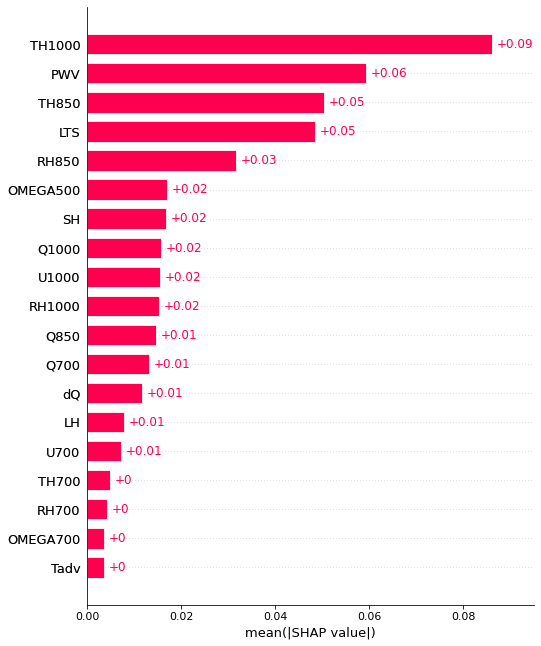

In [31]:
shap.plots.bar(shap_values, max_display=20)

In [32]:
#shap_values

In [33]:
X_sampled

,TH1000,TH850,TH700,RH1000,RH850,RH700,Q1000,Q850,Q700,U1000,U700,OMEGA500,OMEGA700,PWV,LH,SH,Tadv,dQ,LTS
472177,-0.079182,-0.020548,0.008190,0.480374,-1.009714,-0.443131,-0.236347,-0.543816,-0.375116,-0.269717,0.311853,0.837915,0.585004,-0.310765,0.573250,0.467907,0.197918,-0.108384,0.291161
843807,-0.639708,-0.617491,-0.578471,-0.586258,-1.024831,-1.229478,-0.826020,-0.968020,-0.970607,0.299060,0.943051,1.669527,0.877699,-0.891527,-0.115543,-0.646221,-0.048771,-0.596454,0.041603
651315,0.460377,0.335027,0.478917,0.115255,0.677470,-0.364916,0.322078,0.491980,0.029123,-0.365096,-1.013411,-1.269163,0.105179,0.386834,-0.276858,0.080801,-0.078923,0.455934,0.194482
582148,-0.123324,-0.029063,0.150942,-0.130179,-0.476335,-0.113808,-0.335747,-0.313876,0.008334,-0.791025,1.201322,-0.400969,0.707360,-0.054631,0.167631,0.000430,0.708040,-0.500024,0.948800
1079740,1.109182,1.033078,0.948596,0.498566,0.660338,1.041225,1.333214,1.495775,1.688410,-1.083321,-0.603310,0.713539,-0.098748,1.480182,0.532435,0.441361,0.080615,0.884792,-0.267164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858820,1.198826,1.092654,0.854416,0.904219,-0.052807,0.459057,1.581713,1.142924,1.077422,-1.191673,-1.159388,0.201401,0.304306,1.361912,0.223023,0.396385,0.118977,1.641608,-0.901142
129670,1.222171,1.114271,1.007611,0.148129,0.551117,1.149909,1.440159,1.562861,1.902908,-0.790212,-0.959789,-0.727760,-1.005620,1.671407,0.018561,0.202463,-0.161229,0.905214,-0.429207
735203,0.438395,0.516647,0.543503,0.607400,0.307230,0.146399,0.395398,0.505374,0.427692,-1.651693,-0.446157,-0.293663,-0.079554,0.523981,-0.114183,-0.186118,0.157999,0.309114,0.498667
386933,-0.329706,-0.603025,-0.381064,-2.347061,0.680620,-0.068719,-0.766642,-0.482775,-0.348280,-0.651635,2.064808,0.398941,-0.038769,-0.480008,-0.959237,-1.163836,0.120324,-0.906889,-0.275779


In [34]:
### output ###

var = 'XGB'
os.system("mkdir -p /glade/work/hpzhang/LCC_pred/data/{}".format(var))
np.save("/glade/work/hpzhang/LCC_pred/data/{}/y_pred_XGB.npy".format(var), np.array(y_pred_XGB))

np.save("/glade/work/hpzhang/LCC_pred/data/{}/shap_values.npy".format(var), np.array(shap_values.values))
np.save("/glade/work/hpzhang/LCC_pred/data/{}/shap_data.npy".format(var), np.array(shap_values.data))
